In [1]:
#@title **Importar bibliotecas necessárias** { vertical-output: true, form-width: "60%" }

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Importar arquivos CSV

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/INFLUD21-01-05-2023.csv', sep=';')



Mounted at /content/drive/


/tmp/ipython-input-2-946287786.py:4: DtypeWarning: Columns (15,59,61,62,63,91,93,105,107,114,116,117,118,122,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/INFLUD21-01-05-2023.csv', sep=';')


## Filtro de colunas

In [47]:
desired_columns = ['DT_NOTIFIC', 'SEM_NOT', 'SEM_PRI', 'SG_UF_NOT','DT_SIN_PRI', 'SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_UNIDADE', 'CO_UNI_NOT', 'CS_SEXO', 'DT_NASC', 'NU_IDADE_N', 'TP_IDADE', 'COD_IDADE', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_PAIS', 'SG_UF', 'ID_RG_RESI', 'CO_RG_RESI', 'ID_MN_RESI', 'CO_MUN_RES', 'CS_ZONA', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO']

# Garantir que as datas estejam em datetime
df['DT_INTERNA'] = pd.to_datetime(df['DT_INTERNA'], errors='coerce')
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], errors='coerce')

# Filtrar casos incoerentes
incoerentes = df[
    (df['NOSOCOMIAL'] == 1) &
    (df['DT_SIN_PRI'].notna()) &
    (df['DT_INTERNA'].notna()) &
    (df['DT_SIN_PRI'] < df['DT_INTERNA'])
]

# Visualizar os primeiros incoerentes
incoerentes[['NOSOCOMIAL', 'DT_SIN_PRI', 'DT_INTERNA']].head(15)


,NOSOCOMIAL,DT_SIN_PRI,DT_INTERNA
182,1,2021-05-01,2021-08-01
773,1,2021-06-02,2021-10-02
1199,1,2021-04-02,2021-11-01
1420,1,2021-09-01,2021-12-01
1622,1,2021-01-03,2021-03-03
2100,1,2021-06-03,2021-10-03
2143,1,2021-01-03,2021-10-03
3065,1,2021-10-03,2021-11-03
3074,1,2021-05-03,2021-09-03
3090,1,2021-01-03,2021-10-02


## Análise: As taxas de óbito e cura diferem entre os sexos?


,Cura,Óbito,Total,Taxa_óbito (%),Taxa_cura (%)
Masculino,19426,8093,27519,29.41,70.59
Feminino,16116,6365,22481,28.31,71.69
Total Geral,35542,14458,50000,28.92,71.08


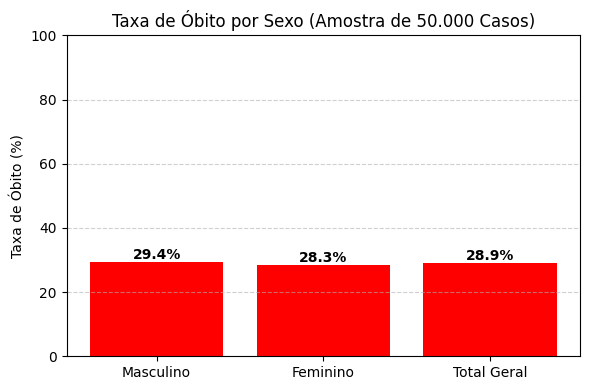

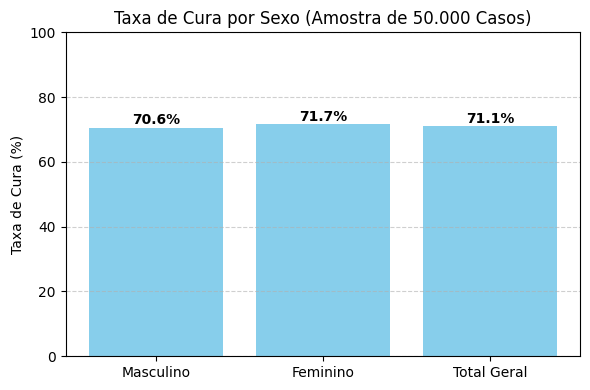

In [ ]:
# Mapeamento dos valores de SEXO e EVOLUCAO para 1 e 2. Isso foi feito com a finalidade de facilitar a utilização das colunas
df['CS_SEXO'] = df['CS_SEXO'].astype(str).str.strip().str.upper()
sexo_map = {'M': 1, 'F': 2}
df['CS_SEXO_NUM'] = df['CS_SEXO'].map(sexo_map)
df['EVOLUCAO'] = pd.to_numeric(df['EVOLUCAO'], errors='coerce').astype('Int64')

# Filtragem de dados válidos. Algumas linhas apresentavam valores 'NaN' que estavam afetando a análise, portanto, foi necessário um tratamento prévio
df_validos = df[(df['CS_SEXO_NUM'].isin([1, 2])) & (df['EVOLUCAO'].isin([1, 2]))]

# Sortear amostra com base nos dados filtrados
amostra_50k_taxa_obito = df_validos.sample(n=min(50000, len(df_validos)), random_state=42)

# Tabela de contingência
tabela = pd.crosstab(amostra_50k_taxa_obito['CS_SEXO_NUM'], amostra_50k_taxa_obito['EVOLUCAO'])

# Calcular totais e taxa
tabela['Total'] = tabela[1] + tabela[2]
tabela['Taxa_óbito (%)'] = (tabela[2] / tabela['Total']) * 100
tabela['Taxa_cura (%)'] = (tabela[1] / tabela['Total']) * 100

# Renomear índices para leitura
tabela.index = tabela.index.map({1: 'Masculino', 2: 'Feminino'})

# Remover os índices anteriores para melhorar a visualização da tabela de contingência
tabela.index.name = None
tabela.columns.name = None

# Tabela final com totais
tabela_final = tabela[[1, 2, 'Total', 'Taxa_óbito (%)', 'Taxa_cura (%)']].rename(columns={1: 'Cura', 2: 'Óbito'})

# Calcular totais gerais
total_cura = tabela_final['Cura'].sum()
total_obito = tabela_final['Óbito'].sum()
total_geral = total_cura + total_obito
taxa_obito_global = (total_obito / total_geral) * 100
taxa_cura_global = (total_cura / total_geral) * 100

# Constrói a tabela final
tabela_final.loc['Total Geral'] = [
    total_cura,
    total_obito,
    total_geral,
    taxa_obito_global,
    taxa_cura_global
]

# Arredondar colunas de taxa (2 casas decimais)
tabela_final['Taxa_óbito (%)'] = tabela_final['Taxa_óbito (%)'].round(2)
tabela_final['Taxa_cura (%)'] = tabela_final['Taxa_cura (%)'].round(2)

# Converter colunas de contagem para inteiros
tabela_final[['Cura', 'Óbito', 'Total']] = tabela_final[['Cura', 'Óbito', 'Total']].astype(int)

display(tabela_final)
print()

# Plotar histograma da taxa de óbito
plt.figure(figsize=(6, 4))
plt.bar(tabela_final.index, tabela_final['Taxa_óbito (%)'], color='red')
plt.title('Taxa de Óbito por Sexo (Amostra de 50.000 Casos)')
plt.ylabel('Taxa de Óbito (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionar os valores no topo das barras
for i, v in enumerate(tabela_final['Taxa_óbito (%)']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print()

# Plotar histograma da taxa de cura
plt.figure(figsize=(6, 4))
plt.bar(tabela_final.index, tabela_final['Taxa_cura (%)'], color='skyblue')
plt.title('Taxa de Cura por Sexo (Amostra de 50.000 Casos)')
plt.ylabel('Taxa de Cura (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionar os valores no topo das barras
for i, v in enumerate(tabela_final['Taxa_cura (%)']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## Análise: Distribuição dos sintomas de FEBRE, DIARREIA E TOSSE entre gestantes


Total de gestantes (1º ao 3º trimestre) encontradas no dataset: 16140
Proporção de gestantes na base: 0.93%

Distribuição de sintomas entre gestantes:


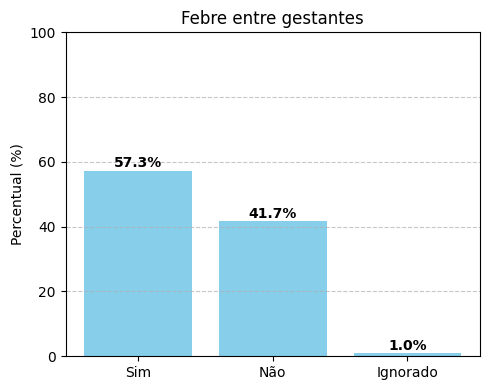


Idade média das gestantes com febre: 28.91 anos


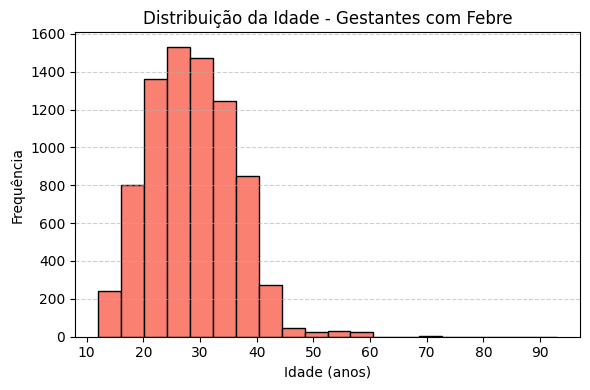

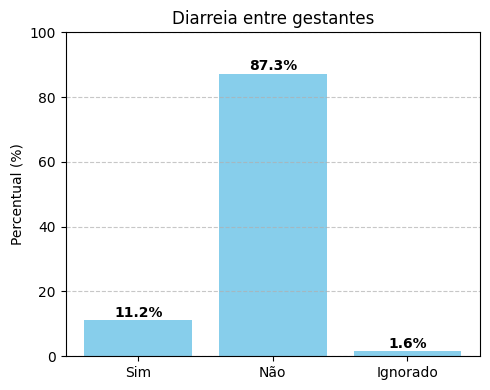


Idade média das gestantes com diarreia: 29.62 anos


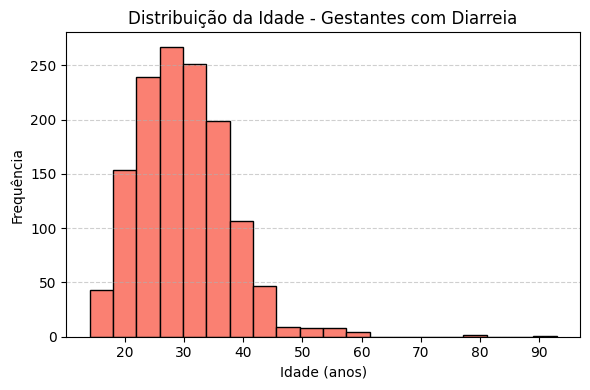

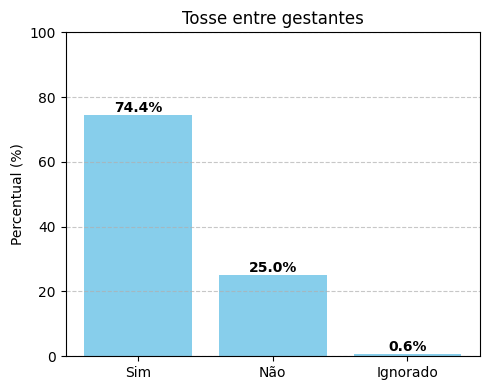


Idade média das gestantes com tosse: 29.22 anos


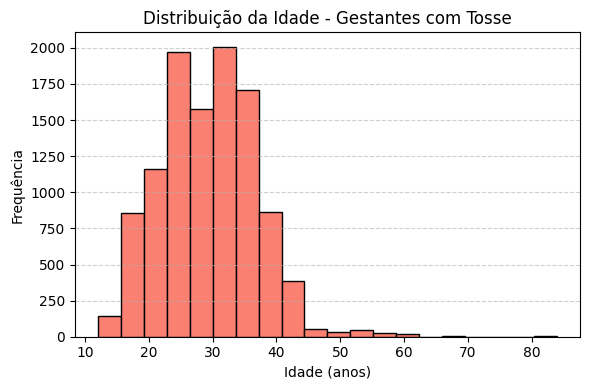

In [ ]:
# Garantir que as colunas estão no tipo certo para serem analisadas
df['CS_GESTANT'] = pd.to_numeric(df['CS_GESTANT'], errors='coerce').astype('Int64')
df['FEBRE'] = pd.to_numeric(df['FEBRE'], errors='coerce').astype('Int64')
df['DIARREIA'] = pd.to_numeric(df['DIARREIA'], errors='coerce').astype('Int64')
df['TOSSE'] = pd.to_numeric(df['TOSSE'], errors='coerce').astype('Int64')

# Filtrar os casos de gestantes (valores 1, 2 ou 3)
gestantes = df[df['CS_GESTANT'].isin([1, 2, 3])]

# Mostrar contagens
total_geral = df.shape[0]
total_gestantes = gestantes.shape[0]
proporcao = (total_gestantes / total_geral) * 100

print(f"Total de gestantes (1º ao 3º trimestre) encontradas no dataset: {total_gestantes}")
print(f"Proporção de gestantes na base: {proporcao:.2f}%")

# Análise de sintomas entre gestantes
print("\nDistribuição de sintomas entre gestantes:")

# Mapeamento para rótulos
rotulos = {1: 'Sim', 2: 'Não', 9: 'Ignorado'}

# Gráficos de sintomas
for sintoma in ['FEBRE', 'DIARREIA', 'TOSSE']:
    contagem = gestantes[sintoma].value_counts(normalize=True).sort_index() * 100
    contagem = contagem.rename(index=rotulos)

    plt.figure(figsize=(5, 4))
    bars = plt.bar(contagem.index, contagem.values, color='skyblue')
    plt.title(f'{sintoma.capitalize()} entre gestantes')
    plt.ylabel('Percentual (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Rótulos no topo das barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
    print()

    # Filtro para selecionar apenas resultados positivos e adiciona uma verificação na coluna da idade
    gestantes_com_sintoma = gestantes[(gestantes[sintoma] == 1) & (gestantes['NU_IDADE_N'].notna())]

    if not gestantes_com_sintoma.empty:
        media_idade = gestantes_com_sintoma['NU_IDADE_N'].mean()
        print(f"Idade média das gestantes com {sintoma.lower()}: {media_idade:.2f} anos")
        plt.figure(figsize=(6, 4))
        plt.hist(gestantes_com_sintoma['NU_IDADE_N'], bins=20, color='salmon', edgecolor='black')
        plt.title(f'Distribuição da Idade - Gestantes com {sintoma.capitalize()}')
        plt.xlabel('Idade (anos)')
        plt.ylabel('Frequência')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    print()


## Análise: Pacientes nosocomiais (pacientes que contraíram a infecção após estarem internados)

In [55]:
# Garante que os valores sejam numéricos
df['NOSOCOMIAL'] = pd.to_numeric(df['NOSOCOMIAL'], errors='coerce')

# Filtra registros válidos (1, 2, 9)
registros_validos = df[df['NOSOCOMIAL'].isin([1, 2, 9])]

# Contagem de casos nosocomiais
casos_nosocomiais = (registros_validos['NOSOCOMIAL'] == 1).sum()

# Total de válidos
total_validos = len(registros_validos)

# Porcentagem
porcentagem_nosocomial = (casos_nosocomiais / total_validos) * 100

print(f"Casos nosocomiais (NOSOCOMIAL = 1): {casos_nosocomiais} de {total_validos} registros válidos ({porcentagem_nosocomial:.2f}%)")


Casos nosocomiais (NOSOCOMIAL = 1): 26905 de 1427132 registros válidos (1.89%)


## Existe diferença nos desfechos (evolução) entre pacientes nosocomiais e não-nosocomiais?

,Cura,Óbito,Total,Taxa_óbito (%),Taxa_cura (%)
Nosocomial,13952,8895,22847,38.93,61.07
Não nosocomial,828067,321076,1149143,27.94,72.06
Total Geral,842019,329971,1171990,28.15,71.85


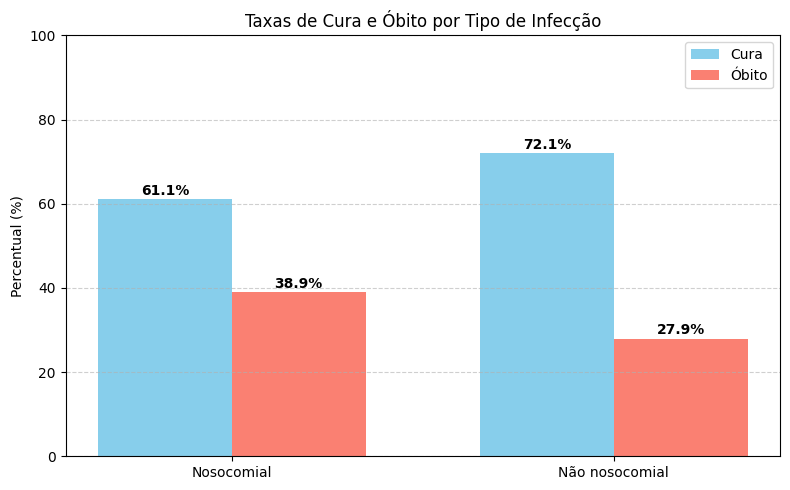

In [52]:
# Garantir que as colunas estão nos tipos corretos
df['NOSOCOMIAL'] = pd.to_numeric(df['NOSOCOMIAL'], errors='coerce').astype('Int64')
df['EVOLUCAO'] = pd.to_numeric(df['EVOLUCAO'], errors='coerce').astype('Int64')

# Filtrar dados válidos: somente quando NOSOCOMIAL é 1 ou 2 e EVOLUCAO é 1 ou 2
df_validos = df[(df['NOSOCOMIAL'].isin([1, 2])) & (df['EVOLUCAO'].isin([1, 2]))]

# Construir tabela de contingência
tabela = pd.crosstab(df_validos['NOSOCOMIAL'], df_validos['EVOLUCAO'])

# Calcular totais e taxas
tabela['Total'] = tabela[1] + tabela[2]
tabela['Taxa_óbito (%)'] = (tabela[2] / tabela['Total']) * 100
tabela['Taxa_cura (%)'] = (tabela[1] / tabela['Total']) * 100

# Renomear índices
tabela.index = tabela.index.map({1: 'Nosocomial', 2: 'Não nosocomial'})
tabela.index.name = None
tabela.columns.name = None

# Reorganizar e renomear colunas
tabela_final = tabela[[1, 2, 'Total', 'Taxa_óbito (%)', 'Taxa_cura (%)']].rename(columns={1: 'Cura', 2: 'Óbito'})

# Totais gerais
total_cura = tabela_final['Cura'].sum()
total_obito = tabela_final['Óbito'].sum()
total_geral = total_cura + total_obito
taxa_obito_global = (total_obito / total_geral) * 100
taxa_cura_global = (total_cura / total_geral) * 100

# Adicionar linha com totais gerais
tabela_final.loc['Total Geral'] = [
    total_cura,
    total_obito,
    total_geral,
    taxa_obito_global,
    taxa_cura_global
]

# Arredondar taxas
tabela_final['Taxa_óbito (%)'] = tabela_final['Taxa_óbito (%)'].round(2)
tabela_final['Taxa_cura (%)'] = tabela_final['Taxa_cura (%)'].round(2)

# Garantir colunas de contagem como inteiros
tabela_final[['Cura', 'Óbito', 'Total']] = tabela_final[['Cura', 'Óbito', 'Total']].astype(int)

display(tabela_final)

# Remover 'Total Geral' se existir, para manter o gráfico limpo
tabela_grafico = tabela_final.drop('Total Geral', errors='ignore')

# Extrair nomes dos grupos e taxas dinamicamente
grupos = tabela_grafico.index.tolist()
taxa_cura = tabela_grafico['Taxa_cura (%)'].values
taxa_obito = tabela_grafico['Taxa_óbito (%)'].values

# Eixo X
x = np.arange(len(grupos))
largura = 0.35

# Criar o gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(8, 5))
bars_cura = ax.bar(x - largura/2, taxa_cura, width=largura, label='Cura', color='skyblue')
bars_obito = ax.bar(x + largura/2, taxa_obito, width=largura, label='Óbito', color='salmon')

ax.set_ylabel('Percentual (%)')
ax.set_title('Taxas de Cura e Óbito por Tipo de Infecção')
ax.set_xticks(x)
ax.set_xticklabels(grupos)
ax.set_ylim(0, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Rótulos nas barras
for bar in bars_cura + bars_obito:
    altura = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, altura + 1, f'{altura:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Os sintomas dos pacientes realmente surgiram após a internação para serem caracterizados como casos nosocomiais?

Total de casos nosocomiais: 26905
Sem ambas as datas preenchidas: 20833 (77.43%)
Com ambas as datas preenchidas: 6072 (22.57%)


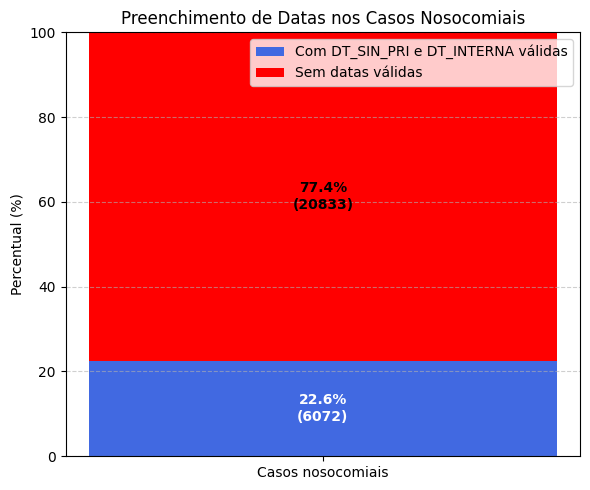


Casos coerentes (sintomas após internação): 3069 de 6072 (50.54%)
Casos incoerentes (sintomas antes da internação): 3003 de 6072 (49.46%)


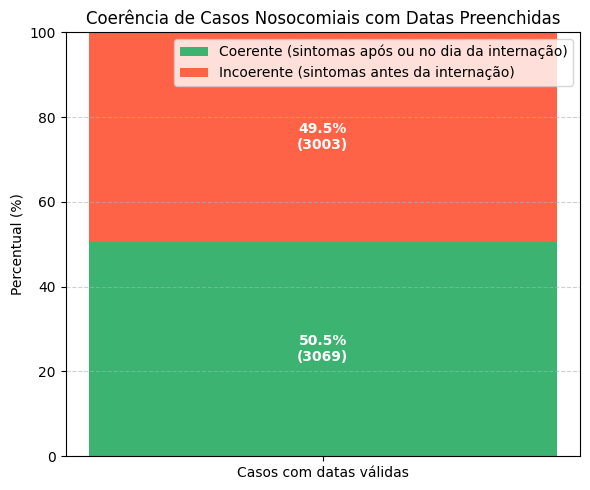

In [67]:
# 1. Criar cópia segura dos casos nosocomiais
df_nosocomial = df[df['NOSOCOMIAL'] == 1].copy()

# 2. Converter datas (apenas na cópia)
df_nosocomial['DT_INTERNA'] = pd.to_datetime(df_nosocomial['DT_INTERNA'], errors='coerce')
df_nosocomial['DT_SIN_PRI'] = pd.to_datetime(df_nosocomial['DT_SIN_PRI'], errors='coerce')

# 3. Manter apenas registros com ambas as datas válidas
df_nosocomial = df_nosocomial[df_nosocomial['DT_INTERNA'].notna() & df_nosocomial['DT_SIN_PRI'].notna()].copy()

# 4. Calcular diferença em dias entre os sintomas e a internação
df_nosocomial['dias_apos_internacao'] = (df_nosocomial['DT_SIN_PRI'] - df_nosocomial['DT_INTERNA']).dt.days

# 5. Estatísticas descritivas da diferença de dias
descricao = df_nosocomial['dias_apos_internacao'].describe().round(2)

# 6. Filtrar casos coerentes e incoerentes
coerentes = df_nosocomial[df_nosocomial['dias_apos_internacao'] >= 0]
incoerentes = df_nosocomial[df_nosocomial['dias_apos_internacao'] < 0]

# 7. Números e proporções
total_validos = len(df_nosocomial)
n_coerentes = len(coerentes)
n_incoerentes = len(incoerentes)
proporcao_coerente = (n_coerentes / total_validos) * 100
proporcao_incoerente = (n_incoerentes / total_validos) * 100

total_nosocomial = (df['NOSOCOMIAL'] == 1).sum()

# Quantos têm DT_INTERNA e DT_SIN_PRI preenchidos?
com_datas = df[(df['NOSOCOMIAL'] == 1) & df['DT_INTERNA'].notna() & df['DT_SIN_PRI'].notna()].shape[0]

coerentes_count = n_coerentes
incoerentes_count = n_incoerentes
total = total_validos

# Proporções
coerentes_pct = (coerentes_count / total) * 100
incoerentes_pct = (incoerentes_count / total) * 100

# Dados
total_nosocomial = (df['NOSOCOMIAL'] == 1).sum()
com_datas = df[(df['NOSOCOMIAL'] == 1) & df['DT_INTERNA'].notna() & df['DT_SIN_PRI'].notna()].shape[0]
sem_datas = total_nosocomial - com_datas

# Percentuais
com_datas_pct = (com_datas / total_nosocomial) * 100
sem_datas_pct = (sem_datas / total_nosocomial) * 100

# Gráfico comparativo entre nosocomiais com datas devidamente preenchidas com nosocomiais inválidos
print(f"Total de casos nosocomiais: {total_nosocomial}")
print(f"Sem ambas as datas preenchidas: {sem_datas} ({(sem_datas_pct):.2f}%)")
print(f"Com ambas as datas preenchidas: {com_datas} ({(com_datas_pct):.2f}%)")

plt.figure(figsize=(6, 5))
plt.bar('Casos nosocomiais', com_datas_pct, label='Com DT_SIN_PRI e DT_INTERNA válidas', color='royalblue')
plt.bar('Casos nosocomiais', sem_datas_pct, bottom=com_datas_pct, label='Sem datas válidas', color='red')

plt.ylabel('Percentual (%)')
plt.title('Preenchimento de Datas nos Casos Nosocomiais')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

plt.text(0, com_datas_pct / 2, f'{com_datas_pct:.1f}%\n({com_datas})', ha='center', va='center', color='white', fontweight='bold')
plt.text(0, com_datas_pct + (sem_datas_pct / 2), f'{sem_datas_pct:.1f}%\n({sem_datas})', ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()


print(f"\nCasos coerentes (sintomas após internação): {n_coerentes} de {total_validos} ({proporcao_coerente:.2f}%)")
print(f"Casos incoerentes (sintomas antes da internação): {n_incoerentes} de {total_validos} ({proporcao_incoerente:.2f}%)")

# Gráfico
plt.figure(figsize=(6, 5))
plt.bar('Casos com datas válidas', coerentes_pct, label='Coerente (sintomas após ou no dia da internação)', color='mediumseagreen')
plt.bar('Casos com datas válidas', incoerentes_pct, bottom=coerentes_pct, label='Incoerente (sintomas antes da internação)', color='tomato')

plt.ylabel('Percentual (%)')
plt.title('Coerência de Casos Nosocomiais com Datas Preenchidas')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

plt.text(0, coerentes_pct / 2, f'{coerentes_pct:.1f}%\n({coerentes_count})', ha='center', va='center', color='white', fontweight='bold')
plt.text(0, coerentes_pct + (incoerentes_pct / 2), f'{incoerentes_pct:.1f}%\n({incoerentes_count})', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()
